In [1]:
import numpy as np
import pandas as pd
import os
import random
import re
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.efficientnet import preprocess_input, EfficientNetB0
from keras.layers import Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import load_model
import itertools
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
base_path = "E:/desktop/master_assign/ece9039/project/garbage_classification/"

categories = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

In [3]:
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

In [4]:
filenames_list = []
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + category)
    
    filenames_list += filenames
    categories_list += [category] * len(filenames)

df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')

df = df.sample(frac=1).reset_index(drop=True)

df.head()

,filename,category
0,clothes/clothes67.jpg,clothes
1,biological/biological677.jpg,biological
2,clothes/clothes885.jpg,clothes
3,clothes/clothes5322.jpg,clothes
4,clothes/clothes2100.jpg,clothes


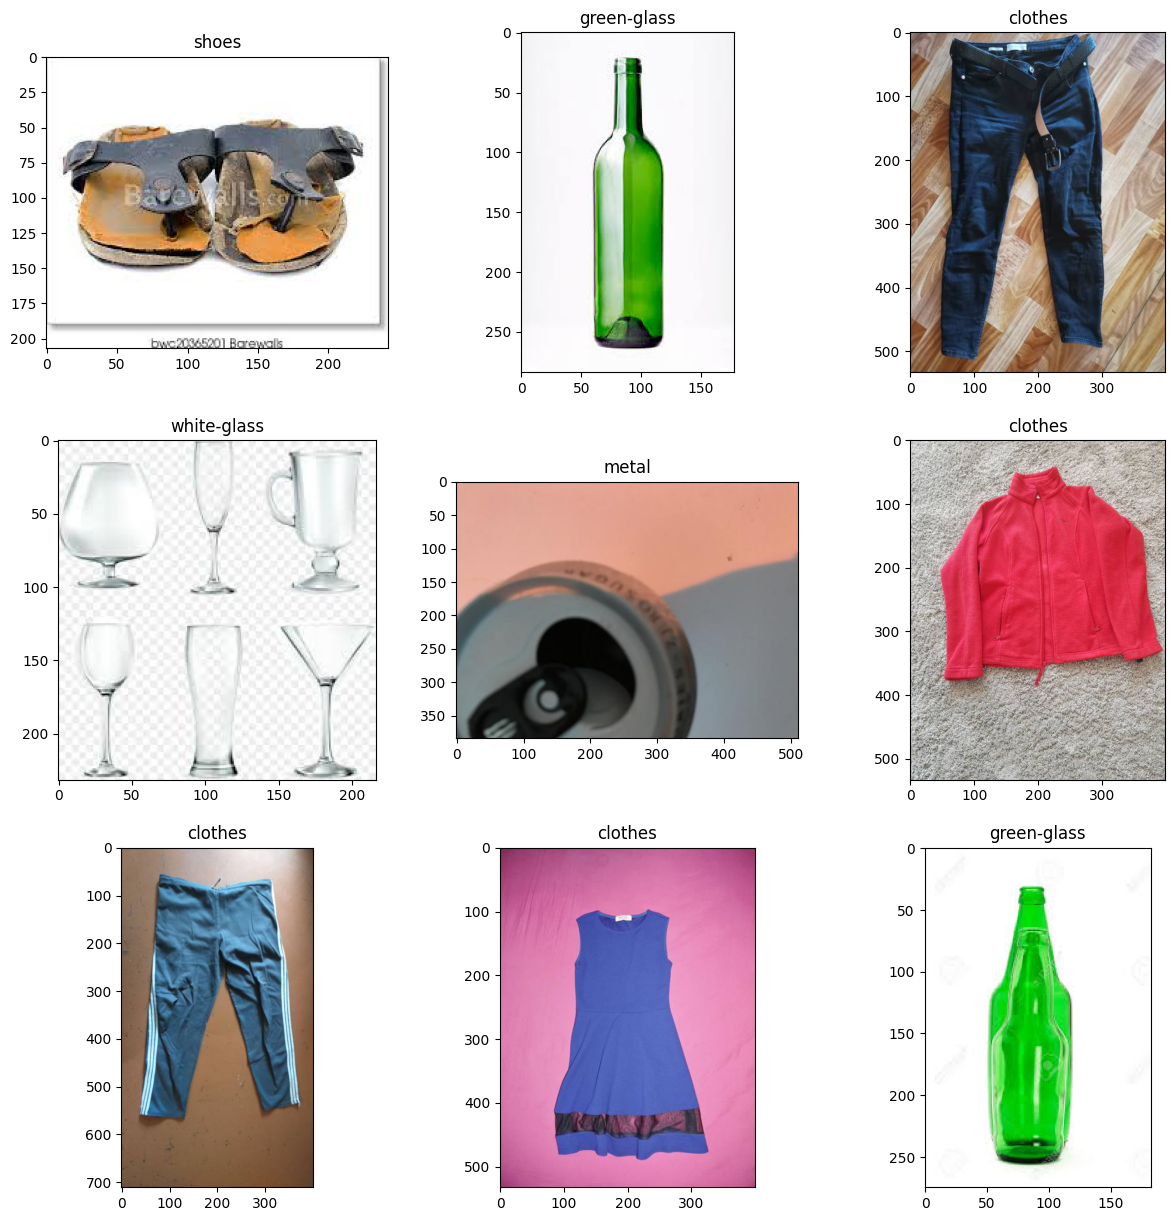

In [5]:

plt.figure(figsize=(15,15))
for i in range(9):
    random_row = random.randint(0, len(df)-1)
    sample = df.iloc[random_row]
    random_image = tf.keras.utils.load_img(base_path + sample['filename'])
    plt.subplot(330 + 1 + i)
    plt.title(sample['category'])
    plt.imshow(random_image)
plt.show()

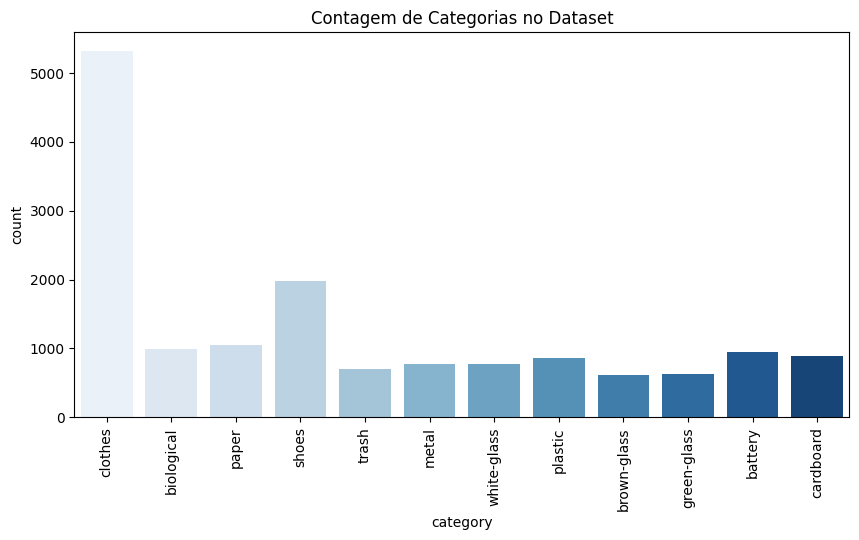

In [6]:
plt.figure(figsize=(10, 5))
sns.countplot(x="category", data=df, palette='Blues')
plt.xticks(rotation=90)
plt.title('Contagem de Categorias no Dataset')
plt.show()

In [7]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [8]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

len(train_df), len(val_df), len(test_df)

(12412, 1551, 1552)

In [9]:
train_df.head()

,filename,category
0,clothes/clothes1852.jpg,clothes
1,clothes/clothes589.jpg,clothes
2,clothes/clothes3983.jpg,clothes
3,clothes/clothes4446.jpg,clothes
4,clothes/clothes956.jpg,clothes


In [10]:
im_shape = (224, 224)
batch_size = 64
seed = 42

In [11]:
train_data_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
val_data_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
test_data_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [12]:
train_generator = train_data_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=im_shape,
    class_mode='categorical',
    batch_size=batch_size,
    seed=seed)

val_generator = val_data_gen.flow_from_dataframe(
    dataframe=val_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=im_shape,
    class_mode='categorical',
    batch_size=batch_size,
    seed=seed)

test_generator = test_data_gen.flow_from_dataframe(
    dataframe=test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=im_shape,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
    seed=seed)

Found 12412 validated image filenames belonging to 12 classes.
Found 1551 validated image filenames belonging to 12 classes.
Found 1552 validated image filenames belonging to 12 classes.


In [13]:
nb_train_samples = train_generator.samples
nb_validation_samples = val_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [14]:
model = Sequential()
# Block 1
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))
# Block 2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))
# Block 3
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))
# Block 4
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))
# Block 5
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))
model.add(Dropout(rate=0.5))
# Flatten the feature map to a 1D vector
model.add(Flatten())
# Dense layers
model.add(Dense(4096, activation='relu', name='fc1'))
model.add(Dropout(rate=0.5))
model.add(Dense(4096, activation='relu',  name='fc2'))
model.add(Dropout(rate=0.5))
model.add(Dense(num_classes, activation='softmax', name='predictions'))
model.build(input_shape=(None, im_shape[0], im_shape[1], 3))
model.summary()

# Compila o modelo
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 224, 224, 3)      12        
 ormalization)                                                   
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 32)      896       
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 32)      9248      
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 32)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 64)      18496     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 64)      36928     
                                                        

In [15]:
%%time
epochs = 30

#Callback to save the best model
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

#Training
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=val_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // batch_size)

Epoch 1/30
193/193 [==============================] - 56s 230ms/step - loss: 2.2503 - accuracy: 0.3159 - val_loss: 2.1828 - val_accuracy: 0.3379
Epoch 2/30
193/193 [==============================] - 39s 201ms/step - loss: 2.1316 - accuracy: 0.3530 - val_loss: 1.9183 - val_accuracy: 0.4004
Epoch 3/30
193/193 [==============================] - 39s 202ms/step - loss: 1.8032 - accuracy: 0.4245 - val_loss: 1.6481 - val_accuracy: 0.4564
Epoch 4/30
193/193 [==============================] - 40s 206ms/step - loss: 1.6648 - accuracy: 0.4600 - val_loss: 1.5686 - val_accuracy: 0.4740
Epoch 5/30
193/193 [==============================] - 38s 197ms/step - loss: 1.4669 - accuracy: 0.5170 - val_loss: 1.3150 - val_accuracy: 0.5684
Epoch 6/30
193/193 [==============================] - 38s 197ms/step - loss: 1.3416 - accuracy: 0.5579 - val_loss: 1.1737 - val_accuracy: 0.6133
Epoch 7/30
193/193 [==============================] - 38s 198ms/step - loss: 1.2381 - accuracy: 0.5964 - val_loss: 1.1132 - val_ac

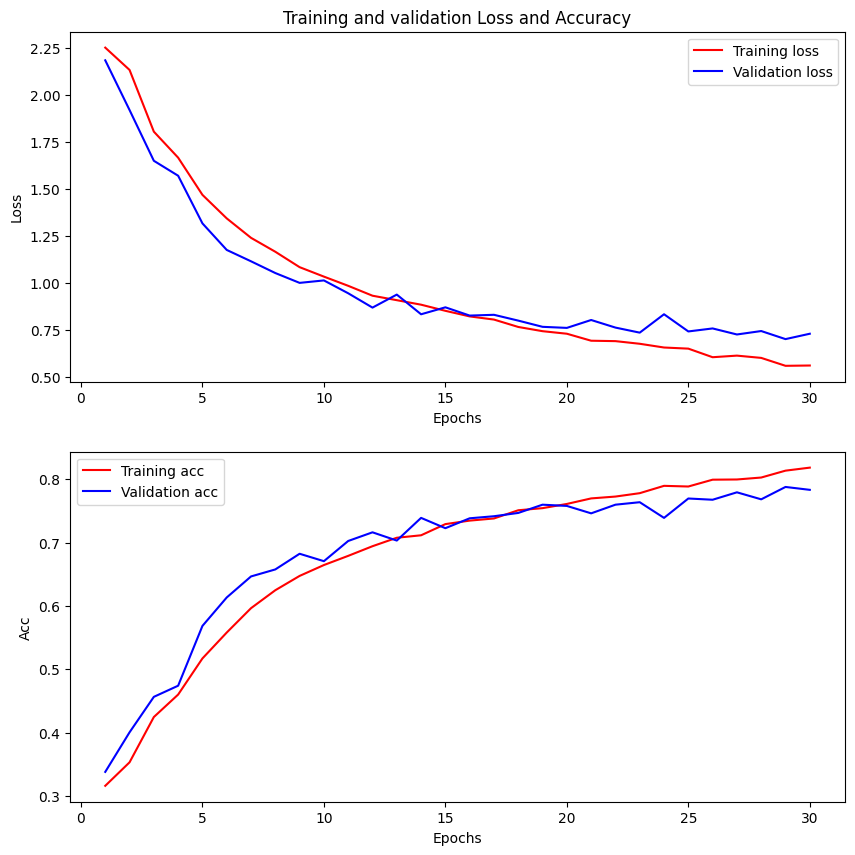

In [16]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'r', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'r', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [17]:
score = model.evaluate(val_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

25/25 [==============================] - 3s 125ms/step - loss: 0.7389 - accuracy: 0.7834
Val loss: 0.7389340996742249
Val accuracy: 0.7833655476570129


In [18]:
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1552/1552 [==============================] - 6s 4ms/step - loss: 0.6831 - accuracy: 0.7771
Test loss: 0.6830756068229675
Test accuracy: 0.7770618796348572


1552/1552 [==============================] - 5s 3ms/step
Classification Report
              precision    recall  f1-score   support

     battery       0.88      0.60      0.71        77
  biological       0.70      0.72      0.71        96
 brown-glass       0.69      0.65      0.67        62
   cardboard       0.79      0.79      0.79        84
     clothes       0.90      0.96      0.93       559
 green-glass       0.94      0.79      0.86        58
       metal       0.39      0.49      0.44        71
       paper       0.62      0.82      0.70        93
     plastic       0.71      0.48      0.57        86
       shoes       0.75      0.77      0.76       196
       trash       0.79      0.65      0.71        84
 white-glass       0.65      0.52      0.58        86

    accuracy                           0.78      1552
   macro avg       0.73      0.69      0.70      1552
weighted avg       0.78      0.78      0.78      1552



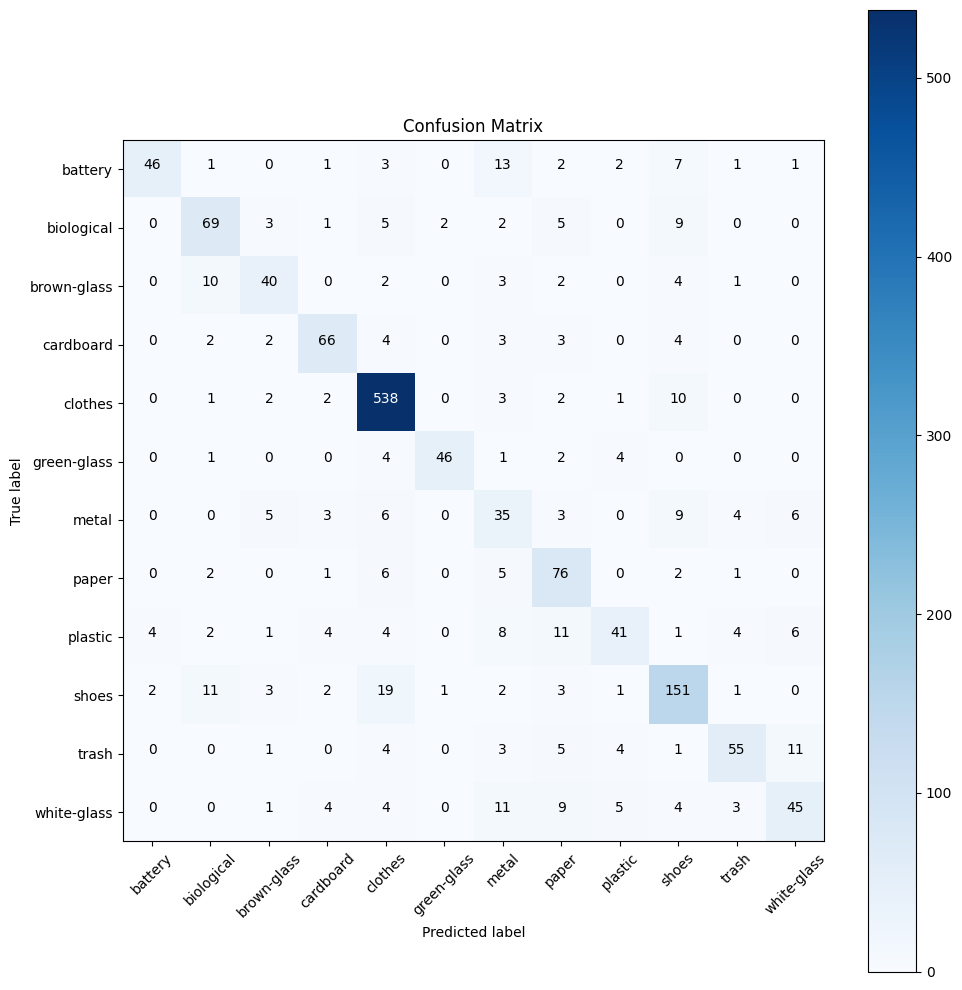

In [19]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

# Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))